('fine_tune_before', 0.35, 6.9914360500517345, 0.31908203856145056, 0.03943042953468336, 0.08535001784245655)


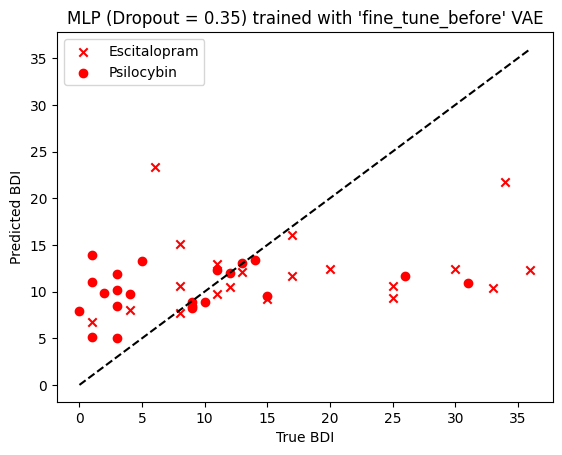

('fine_tune_combined', 0.25, 6.970847311474028, 0.3831706444945473, 0.012255425355246412, 0.13171304042722387)


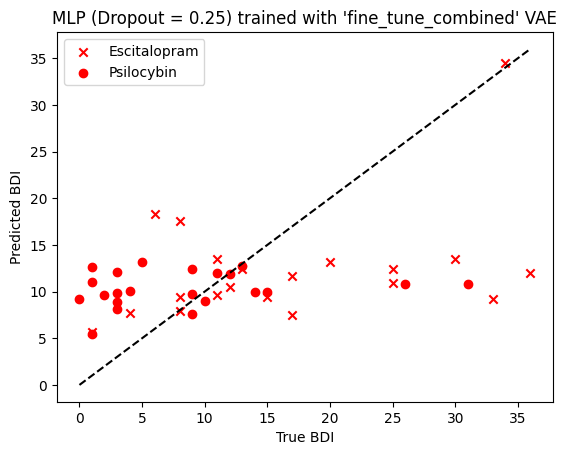

('ica_before', 0.1, 5.366585388070061, 0.7042735891772293, 1.9457198464912132e-07, 0.4783899705313094)


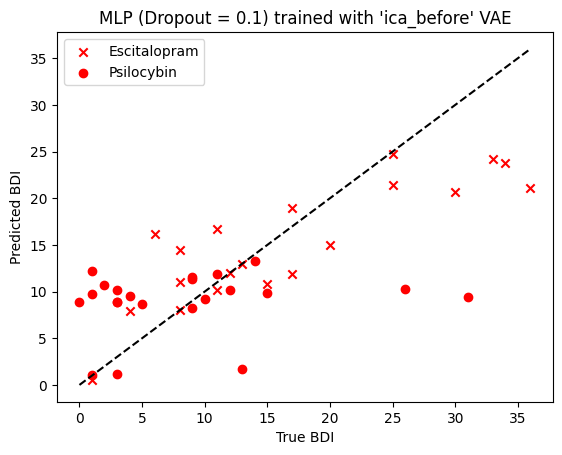

('ica_combined', 0.2, 5.670555724984124, 0.6130324089437118, 1.5895262774299407e-05, 0.35554177075741444)


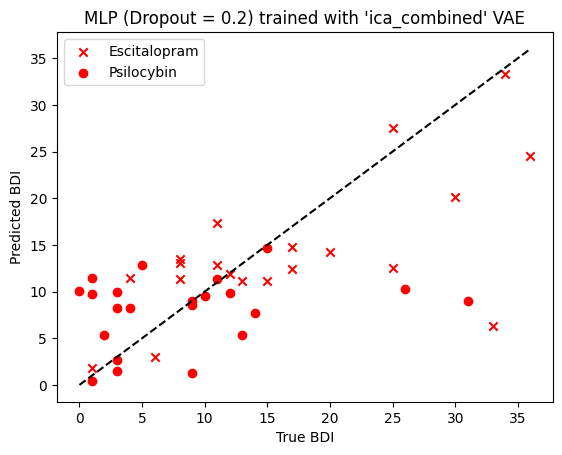

('schaefer_before', 0.25, 5.5860496163368225, 0.639662606430059, 5.100928127399989e-06, 0.40029298583730544)


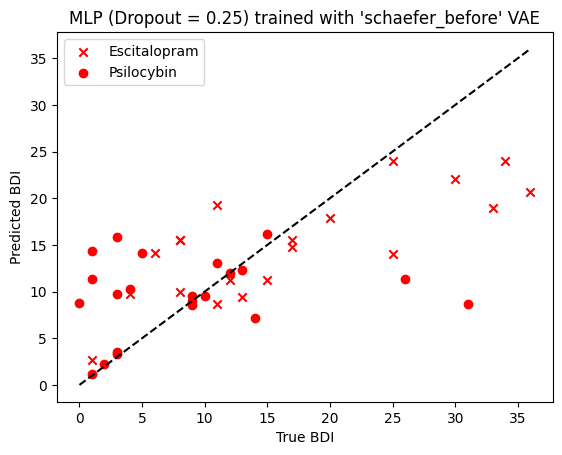

('schaefer_combined', 0, 5.555521795792239, 0.6187669037670146, 1.2554554941558322e-05, 0.37870154579855375)


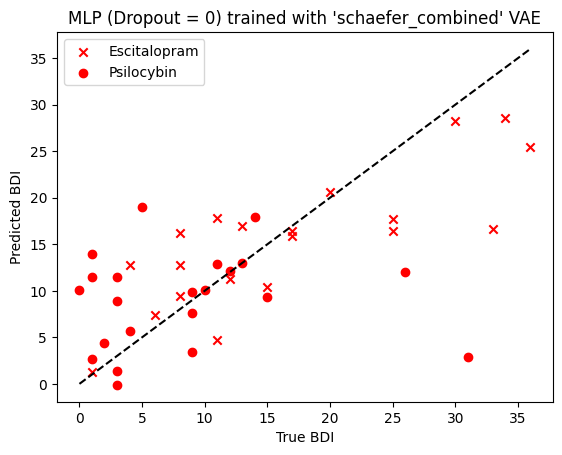

('aal_before', 0.45, 5.806365001769293, 0.4477966757129156, 0.002942573115677376, 0.16242903719531654)


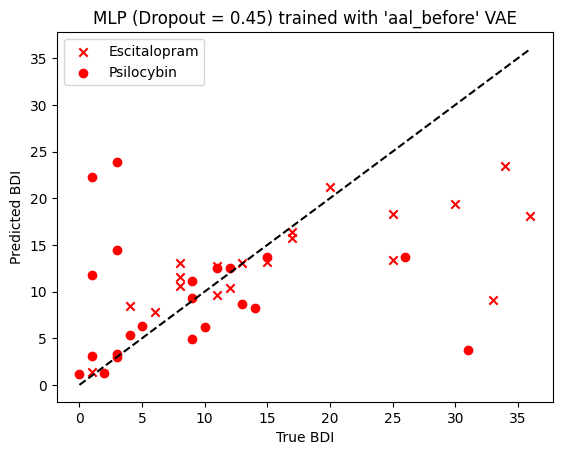

('aal_combined', 0.15, 6.012341286454882, 0.5359831486989078, 0.0002539071522576265, 0.2597971098942208)


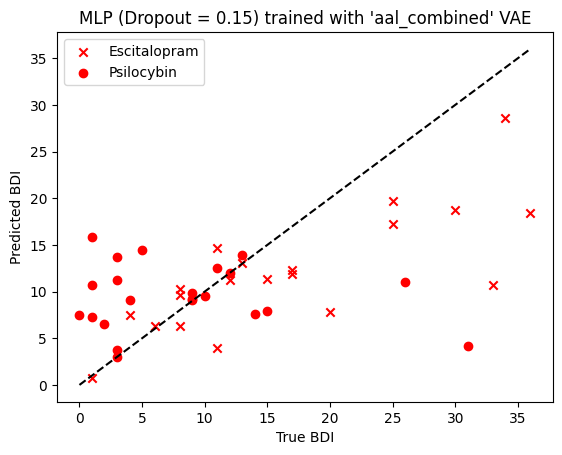

In [17]:
import sys
sys.path.append('../')

from models import LatentMLP, VAE
from utils import BrainGraphDataset, project_root, get_data_labels
import torch
import torch.optim as optim
import os
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
import copy
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

root = project_root()

categories = ['patient_n','condition','bdi_before']

data_labels = get_data_labels()
data_labels = data_labels[categories]

annotations = 'annotations.csv'

data_labels.loc[data_labels["condition"] == "P", "condition"] = 1
data_labels.loc[data_labels["condition"] == "E", "condition"] = -1
data_labels['condition'] = data_labels['condition'].astype('float64')


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataroot = 'fc_matrices/psilo_ica_100_before/'
psilo_ica_before_dataset = BrainGraphDataset(img_dir=os.path.join(root, dataroot),
                            annotations_file=os.path.join(root, annotations),
                            transform=None, extra_data=data_labels, setting='upper_triangular_and_baseline')

dataroot = 'fc_matrices/psilo_schaefer_before/'
psilo_schaefer_before_dataset = BrainGraphDataset(img_dir=os.path.join(root, dataroot),
                            annotations_file=os.path.join(root, annotations),
                            transform=None, extra_data=data_labels, setting='upper_triangular_and_baseline')

dataroot = 'fc_matrices/psilo_aal_before/'
psilo_aal_before_dataset = BrainGraphDataset(img_dir=os.path.join(root, dataroot),
                            annotations_file=os.path.join(root, annotations),
                            transform=None, extra_data=data_labels, setting='upper_triangular_and_baseline')

configs = [
    (psilo_ica_before_dataset, 'vae_fine_tune_before_dropout_0.pt', 'fine_tune_before'),
    (psilo_ica_before_dataset, 'vae_fine_tune_combined_dropout_0.pt', 'fine_tune_combined'),
    (psilo_ica_before_dataset, 'vae_dropout_psilo_ica_before_0.pt', 'ica_before'),
    (psilo_ica_before_dataset, 'vae_dropout_psilo_ica_combined_0.pt', 'ica_combined'),
    (psilo_schaefer_before_dataset, 'vae_dropout_psilo_schaefer_before_0.pt', 'schaefer_before'),
    (psilo_schaefer_before_dataset, 'vae_dropout_psilo_schaefer_combined_0.pt', 'schaefer_combined'),
    (psilo_aal_before_dataset, 'vae_dropout_psilo_aal_before_0.pt', 'aal_before'),
    (psilo_aal_before_dataset, 'vae_dropout_psilo_aal_combined_0.pt', 'aal_combined'),
]


results = []

for config in configs:
    # instantiate the VGAE model
    hidden_dim = 64
    latent_dim = 64
    output_dim = 1
    input_dim = 6670 if 'aal' in config[1] else 4950
    lr = 0.001
    batch_size = 8

    vae = VAE(input_dim, [128] * 2, latent_dim)

    # load the trained VGAE weights
    with torch.no_grad():
        vae.load_state_dict(torch.load(os.path.join(root, f'vae_weights/{config[1]}'), map_location=device))

    # define the optimizer and the loss function
    criterion = nn.L1Loss(reduction='sum')

    # Convert the model to the device
    vae.to(device)

    dataset = config[0]

    # Assuming you have your dataset defined as 'dataset'
    num_folds = 5  # Specify the number of folds
    batch_size = 8  # Specify your desired batch size
    random_seed = 42  # Specify the random seed

    # Create indices for k-fold cross-validation with seeded random number generator
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=random_seed)

    # Create empty lists to store train and validation loaders
    train_loaders = []
    val_loaders = []

    for train_index, val_index in kf.split(dataset):
        # Split dataset into train and validation sets for the current fold
        train_set = torch.utils.data.Subset(dataset, train_index)
        val_set = torch.utils.data.Subset(dataset, val_index)

        # Define the dataloaders for the current fold
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_set, batch_size=len(val_index), shuffle=False)

        # Append the loaders to the respective lists
        train_loaders.append(train_loader)
        val_loaders.append(val_loader)

    num_epochs = 500

    dropout_list = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

    best_r2 = -float('inf')
    best_result = None
    ye = None
    
    for dropout in dropout_list:
          
        val_label = []
        val_output = []
        val_base = []
        
        for t, train_loader in enumerate(train_loaders):
            val_loader = val_loaders[t]
            # instantiate the LatentMLP model

            mlp = LatentMLP(latent_dim, hidden_dim, output_dim, dropout=dropout)
            optimizer = optim.Adam(mlp.parameters(), lr=lr)
            # Convert the MLP to the device
            mlp.to(device)


            mlp.load_state_dict(torch.load(os.path.join(root, f'mlp_weights/mlp_weight_dropout_{dropout}_{config[2]}_{t}.pt'), 
                                           map_location=device))
            vae.load_state_dict(torch.load(os.path.join(root, f'mlp_weights/vae_unfrozen_dropout_{dropout}_{config[2]}_{t}.pt'), 
                                            map_location=device))

            mlp.eval()
            vae.eval()

            optimizer.zero_grad()
            with torch.no_grad():
                for data in val_loader:
                    (graphs, base_bdis), labels = data

                    graphs = graphs.to(device)
                    base_bdis = base_bdis.to(device)

                    labels = labels.to(device).float()

                    # get the latent embeddings from the VGAE
                    _, _, _, zs = vae(graphs.view(-1, input_dim))

                    # pass the latent embeddings through the MLP
                    outputs = mlp(zs, base_bdis)

                    val_label.extend(labels.flatten().tolist())
                    val_output.extend(outputs.flatten().tolist())
                    val_base.extend(base_bdis[:, 0])
            
        corr, p = pearsonr(val_label, val_output)
        r2 = r2_score(val_label, val_output)
        mae = mean_absolute_error(val_label, val_output)

        results.append((config[2], dropout, mae, corr, p, r2))
        if best_r2 < r2:
            best_result = (config[2], dropout, val_label, val_output, val_base)
            ye = results[-1]
            best_r2 = r2
            
    print(ye)
    
    con, dropout, true, pred, drug = best_result
    
    
    for t, p, d in zip(true, pred, drug):
        marker = 'x' if d == -1 else 'o'
        plt.scatter(t, p, color='red', marker=marker)
    
    min_val = min(min(label), min(output))
    max_val = max(max(label), max(output))
    
    plt.plot([min_val, max_val], [min_val, max_val], 'k--')
    plt.title(f'MLP (Dropout = {dropout}) trained with \'{con}\' VAE')
    plt.xlabel('True BDI')
    plt.ylabel('Predicted BDI')
    plt.legend(['Escitalopram', 'Psilocybin'])
    plt.savefig(f'{con}_{dropout}_kfold.png', bbox_inches='tight')
    plt.show()
        
filename = "full-vae-k-fold-results.csv"

import csv
# Writing the results to the CSV file
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Config', 'Dropout', 'MAE', 'Corr', 'P', 'R2'])  # Writing the header
    writer.writerows(results)  # Writing the data rows        